In [1]:
%matplotlib inline
from torch import nn
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm, trange

In [2]:
dataset_train = np.array([mpimg.imread(f"training/images/satImage_{i:03}.png") for i in range(1,101)])
labels_train = np.array([mpimg.imread(f"training/groundtruth/satImage_{i:03}.png").round().astype(np.int8) for i in range(1,101)])
dataset_test = np.array([resize(mpimg.imread(f"test_set_images/test_{i}/test_{i}.png"),dataset_train[0].shape) for i in range(1,51)])

In [3]:
print(f"dataset_train.shape : {dataset_train.shape}")
print(f"labels_train.shape : {labels_train.shape}")
print(f"dataset_test.shape : {dataset_test.shape}")

dataset_train.shape : (100, 400, 400, 3)
labels_train.shape : (100, 400, 400)
dataset_test.shape : (50, 400, 400, 3)


In [4]:
dataset_train = np.moveaxis(dataset_train, -1, 1)
dataset_test = np.moveaxis(dataset_test, -1, 1)

In [5]:
print(f"dataset_train.shape : {dataset_train.shape}")
print(f"dataset_test.shape : {dataset_test.shape}")

dataset_train.shape : (100, 3, 400, 400)
dataset_test.shape : (50, 3, 400, 400)


In [53]:
def imshow(img):
    if len(img.shape) == 3:
        plt.imshow(np.moveaxis(img, 0, -1))
    else:
        plt.imshow(img, cmap='gray')

3


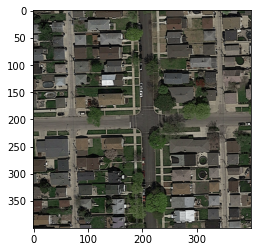

In [7]:
imshow(dataset_train[0])

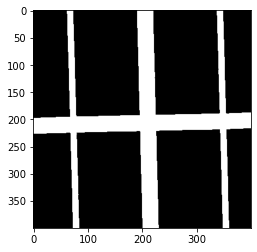

In [54]:
imshow(labels_train[0]);

3


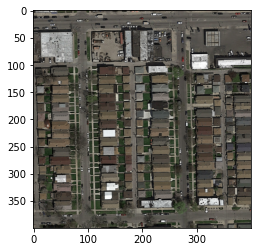

In [9]:
imshow(dataset_test[0]);

In [10]:
random_seed = 0

train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    dataset_train,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    labels_train,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

In [11]:
inputs_train = torch.from_numpy(inputs_train)
inputs_valid = torch.from_numpy(inputs_valid)
targets_train = torch.from_numpy(targets_train).type(torch.LongTensor)
targets_valid = torch.from_numpy(targets_valid).type(torch.LongTensor)

In [35]:
dataset_test = torch.from_numpy(dataset_test)

In [12]:
print(f"inputs_train.shape : {inputs_train.shape}")
print(f"inputs_valid.shape : {inputs_valid.shape}")
print(f"targets_train.shape : {targets_train.shape}")
print(f"targets_valid.shape : {targets_valid.shape}")

inputs_train.shape : torch.Size([80, 3, 400, 400])
inputs_valid.shape : torch.Size([20, 3, 400, 400])
targets_train.shape : torch.Size([80, 400, 400])
targets_valid.shape : torch.Size([20, 400, 400])


In [13]:
print(f"inputs_train.dtype : {inputs_train.dtype}")
print(f"inputs_valid.dtype : {inputs_valid.dtype}")
print(f"targets_train.dtype : {targets_train.dtype}")
print(f"targets_valid.dtype : {targets_valid.dtype}")

inputs_train.dtype : torch.float32
inputs_valid.dtype : torch.float32
targets_train.dtype : torch.int64
targets_valid.dtype : torch.int64


In [14]:
dataset_training = [[inputs_train[i][None], targets_train[i][None]] for i in range(inputs_train.shape[0])]
dataset_valid = [[inputs_valid[i][None], targets_valid[i][None]] for i in range(inputs_valid.shape[0])]

#### Model Creation

In [15]:
@torch.jit.script
def autocrop(encoder_layer: torch.Tensor, decoder_layer: torch.Tensor):
    """
    Center-crops the encoder_layer to the size of the decoder_layer,
    so that merging (concatenation) between levels/blocks is possible.
    This is only necessary for input sizes != 2**n for 'same' padding and always required for 'valid' padding.
    """
    if encoder_layer.shape[2:] != decoder_layer.shape[2:]:
        ds = encoder_layer.shape[2:]
        es = decoder_layer.shape[2:]
        assert ds[0] >= es[0]
        assert ds[1] >= es[1]
        encoder_layer = encoder_layer[
                                    :,
                                    :,
                                    ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                                    ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2)
                                    ]
    return encoder_layer, decoder_layer

def get_up_layer(in_channels: int,
                 out_channels: int,
                 kernel_size: int = 2,
                 stride: int = 2,
                 up_mode: str = 'transposed',
                 ):
    if up_mode == 'transposed':
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
    else:
        return nn.Upsample(scale_factor=2.0, mode=up_mode)

def get_normalization(normalization: str,
                      num_channels: int):
    if normalization == 'batch':
        return nn.BatchNorm2d(num_channels)
    elif normalization == 'instance':
        return nn.InstanceNorm2d(num_channels)
    elif 'group' in normalization:
        num_groups = int(normalization.partition('group')[-1])  # get the group size from string
        return nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)


class Concatenate(nn.Module):
    def __init__(self):
        super(Concatenate, self).__init__()

    def forward(self, layer_1, layer_2):
        x = torch.cat((layer_1, layer_2), 1)

        return x


class DownBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 MaxPool.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 pooling: bool = True,
                 activation = nn.ReLU(),
                 normalization: str = None,
                 conv_mode: str = 'same'):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.activation = activation

        # conv layers
        self.conv1 = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding, bias=True)

        self.conv2 = nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding, bias=True)                           

        # pooling layer
        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # activation layers
        self.act1 = self.activation
        self.act2 = self.activation

        # normalization layers
        if self.normalization:
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels)

    def forward(self, x):
        y = self.conv1(x)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # activation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2

        before_pooling = y  # save the outputs before the pooling operation
        if self.pooling:
            y = self.pool(y)  # pooling
        return y, before_pooling


class UpBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 UpConvolution/Upsample.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 activation = nn.ReLU(),
                 normalization: str = None,
                 conv_mode: str = 'same',
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.activation = activation
        self.up_mode = up_mode

        # upconvolution/upsample layer
        self.up = get_up_layer(self.in_channels, self.out_channels, kernel_size=2, stride=2, up_mode=self.up_mode)

        # conv layers
        self.conv0 = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=1, padding=0, bias=True)

        self.conv1 = nn.Conv2d(2 * self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding, bias=True)
        
        self.conv2 = nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding, bias=True)

        # activation layers
        self.act0 = self.activation
        self.act1 = self.activation
        self.act2 = self.activation

        # normalization layers
        if self.normalization:
            self.norm0 = get_normalization(normalization=self.normalization, num_channels=self.out_channels)
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels)

        # concatenate layer
        self.concat = Concatenate()

    def forward(self, encoder_layer, decoder_layer):
        """ Forward pass
        Arguments:
            encoder_layer: Tensor from the encoder pathway
            decoder_layer: Tensor from the decoder pathway (to be up'd)
        """
        up_layer = self.up(decoder_layer)  # up-convolution/up-sampling
        cropped_encoder_layer, dec_layer = autocrop(encoder_layer, up_layer)  # cropping

        if self.up_mode != 'transposed':
            # We need to reduce the channel dimension with a conv layer
            up_layer = self.conv0(up_layer)  # convolution 0
        up_layer = self.act0(up_layer)  # activation 0
        if self.normalization:
            up_layer = self.norm0(up_layer)  # normalization 0

        merged_layer = self.concat(up_layer, cropped_encoder_layer)  # concatenation
        y = self.conv1(merged_layer)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # acivation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2
        return y


class UNet(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 out_channels: int = 2,
                 n_blocks: int = 4,
                 start_filters: int = 32,
                 activation = nn.ReLU(),
                 normalization: str = 'batch',
                 conv_mode: str = 'same',
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_blocks = n_blocks
        self.start_filters = start_filters
        self.activation = activation
        self.normalization = normalization
        self.conv_mode = conv_mode
        self.up_mode = up_mode

        self.down_blocks = []
        self.up_blocks = []

        # create encoder path
        for i in range(self.n_blocks):
            num_filters_in = self.in_channels if i == 0 else num_filters_out
            num_filters_out = self.start_filters * (2 ** i)
            pooling = True if i < self.n_blocks - 1 else False

            down_block = DownBlock(in_channels=num_filters_in,
                                   out_channels=num_filters_out,
                                   pooling=pooling,
                                   activation=self.activation,
                                   normalization=self.normalization,
                                   conv_mode=self.conv_mode)

            self.down_blocks.append(down_block)

        # create decoder path (requires only n_blocks-1 blocks)
        for i in range(n_blocks - 1):
            num_filters_in = num_filters_out
            num_filters_out = num_filters_in // 2

            up_block = UpBlock(in_channels=num_filters_in,
                               out_channels=num_filters_out,
                               activation=self.activation,
                               normalization=self.normalization,
                               conv_mode=self.conv_mode,
                               up_mode=self.up_mode)

            self.up_blocks.append(up_block)

        # final convolution
        self.conv_final = nn.Conv2d(num_filters_out, self.out_channels, kernel_size=1, stride=1, padding=0, bias=True)

        # add the list of modules to current module
        self.down_blocks = nn.ModuleList(self.down_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)

        # initialize the weights
        self.initialize_parameters()

    @staticmethod
    def weight_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.weight, **kwargs)  # weights

    @staticmethod
    def bias_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.bias, **kwargs)  # bias

    def initialize_parameters(self,
                              method_weights=nn.init.xavier_uniform_,
                              method_bias=nn.init.zeros_,
                              kwargs_weights={},
                              kwargs_bias={}
                              ):
        for module in self.modules():
            self.weight_init(module, method_weights, **kwargs_weights)  # initialize weights
            self.bias_init(module, method_bias, **kwargs_bias)  # initialize bias

    def forward(self, x: torch.tensor):
        encoder_output = []

        # Encoder pathway
        for module in self.down_blocks:
            x, before_pooling = module(x)
            encoder_output.append(before_pooling)

        # Decoder pathway
        for i, module in enumerate(self.up_blocks):
            before_pool = encoder_output[-(i + 2)]
            x = module(before_pool, x)

        x = self.conv_final(x)

        return x

    def __repr__(self):
        attributes = {attr_key: self.__dict__[attr_key] for attr_key in self.__dict__.keys() if '_' not in attr_key[0] and 'training' not in attr_key}
        d = {self.__class__.__name__: attributes}
        return f'{d}'

In [16]:
def accuracy(predicted_logits, reference):
    """
    Compute the ratio of correctly predicted labels
    
    @param predicted_logits: float32 tensor of shape (batch size, num classes)
    @param reference: int64 tensor of shape (batch_size) with the class number
    """
    
    return (reference.numel() - torch.count_nonzero(predicted_logits.argmax(axis=1) - reference))/reference.numel()

In [22]:
def train(model, criterion, dataset_train, dataset_valid, optimizer, num_epochs):
  """
  @param model: torch.nn.Module
  @param criterion: torch.nn.modules.loss._Loss
  @param dataset_train: torch.utils.data.DataLoader
  @param dataset_valid: torch.utils.data.DataLoader
  @param optimizer: torch.optim.Optimizer
  @param num_epochs: int
  """
  print("Starting training")
  for epoch in range(num_epochs):
    # Train an epoch
    model.train()
    for batch_x, batch_y in dataset_train:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)

      # Evaluate the network (forward pass)
      optimizer.zero_grad()
      output = model(batch_x)
      
      # Compute the gradient
      loss = criterion(output,batch_y)
      loss.backward() # backward pass

      # Update the parameters of the model with a gradient step
      optimizer.step() #gradient descent
      # my_lr_scheduler.step()

    # Test the quality on the test set
    model.eval()
    accuracies_test = []
    for batch_x, batch_y in dataset_valid:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)

      # Evaluate the network (forward pass)
      prediction = model(batch_x)
      accuracies_test.append(accuracy(prediction, batch_y))
    print("Epoch {} | Test accuracy: {:.5f}".format(epoch, sum(accuracies_test)/len(accuracies_test)))

In [26]:
dataset_training[0][0].shape

torch.Size([1, 3, 400, 400])

In [27]:
dataset_test.shape

(50, 3, 400, 400)

In [23]:
# If a GPU is available (should be on Colab, we will use it)
if not torch.cuda.is_available():
  raise Exception("Things will go much quicker if you enable a GPU in Colab under 'Runtime / Change Runtime Type'")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model
model = UNet(in_channels=3,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation=nn.ReLU(),
             normalization='batch',
             conv_mode='same').to(device)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 10

In [24]:
train(model, criterion, dataset_training, dataset_valid, optimizer, num_epochs)

Starting training
Epoch 0 | Test accuracy: 0.76615
Epoch 1 | Test accuracy: 0.80884
Epoch 2 | Test accuracy: 0.81631
Epoch 3 | Test accuracy: 0.78543
Epoch 4 | Test accuracy: 0.81407
Epoch 5 | Test accuracy: 0.77837
Epoch 6 | Test accuracy: 0.78417
Epoch 7 | Test accuracy: 0.78877
Epoch 8 | Test accuracy: 0.78798
Epoch 9 | Test accuracy: 0.84548


In [29]:
dataset_test[0][None].shape

(1, 3, 400, 400)

In [36]:
output = model.forward(dataset_test[0][None].to(device))

In [39]:
dataset_test[0].shape

torch.Size([3, 400, 400])

3


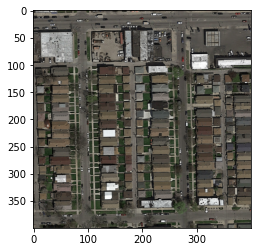

In [40]:
imshow(np.array(dataset_test[0]))

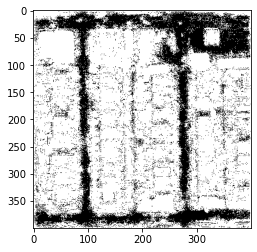

In [69]:
im = np.sign(output[0,0].cpu().detach().numpy())
im = (im + 1)/2
im = im.round()
imshow(im)

In [25]:
# TODO à supprimer ou analyser si besoin
class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

    def run_trainer(self):
        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.batch()  # learning rate scheduler step
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):
        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
            loss = self.criterion(out, target)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):
        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()